# Trump Sentiment Analysis

I seek to analyze and draw conclusions about the current (and often controversial) US President's tweet behavior using data from the Twitter API. 

This project was drawn from UC Berkeley's Principles and Techniques of Data Science class DS100. 

### Load Libraries and Setup

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

# Ensure that Pandas shows at least 280 characters in columns, so we can see full tweets
pd.set_option('max_colwidth', 280)

%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re
import tweepy

In [2]:
# This requires getting your own Twitter developer account and API keys
import json
key_file = 'keys.json'
# Load my Twitter API auth key from my twitter account
with open(key_file) as f:
    keys = json.load(f)

In [ ]:
import tweepy
from tweepy import TweepError
import logging

#ensure my API key is correct
try:
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)
    print("Your username is:", api.auth.get_username())
except TweepError as e:
    logging.warning("There was a Tweepy error. Double check your API keys and try again.")
    logging.warning(e)

In [4]:
from pathlib import Path
import json

ds_tweets_save_path = "BerkeleyData_recent_tweets.json"
# Guarding against attempts to download the data multiple
# times:
if not Path(ds_tweets_save_path).is_file():
    # Getting as many recent tweets by @BerkeleyData as Twitter will let us have.
    # We use tweet_mode='extended' so that Twitter gives us full 280 character tweets.
    # This was a change introduced in September 2017.
    
    # The tweepy Cursor API actually returns "sophisticated" Status objects but we 
    # will use the basic Python dictionaries stored in the _json field. 
    example_tweets = [t._json for t in tweepy.Cursor(api.user_timeline, id="BerkeleyData", 
                                             tweet_mode='extended').items()]
    
    # Saving the tweets to a json file on disk for future analysis
    with open(ds_tweets_save_path, "w") as f:        
        json.dump(example_tweets, f)

# Re-loading the json file:
with open(ds_tweets_save_path, "r") as f:
    example_tweets = json.load(f)

In [5]:
# Looking at one tweet object, which has type Status: 
from pprint import pprint # ...to get a more easily-readable view.
pprint(example_tweets[0])

{'contributors': None,
 'coordinates': None,
 'created_at': 'Wed Oct 17 14:12:03 +0000 2018',
 'display_text_range': [0, 140],
 'entities': {'hashtags': [],
              'symbols': [],
              'urls': [],
              'user_mentions': [{'id': 263020833,
                                 'id_str': '263020833',
                                 'indices': [3, 19],
                                 'name': 'Berkeley School of Information',
                                 'screen_name': 'BerkeleyISchool'},
                                {'id': 24414370,
                                 'id_str': '24414370',
                                 'indices': [26, 34],
                                 'name': 'Anno Saxenian',
                                 'screen_name': 'annosax'}]},
 'favorite_count': 0,
 'favorited': False,
 'full_text': 'RT @BerkeleyISchool: Dean @annosax is one 3 women who have '
              'authored key works to understand the current Entrepreneurial '
           

### Functions for Ease of Use and Reusability

In [6]:
def load_keys(path):
    """Loads your Twitter authentication keys from a file on disk.
    
    Args:
        path (str): The path to your key file.  The file should
          be in JSON format and look like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }
    
    Returns:
        dict: A dictionary mapping key names (like "consumer_key") to
          key values."""
    
    with open(path) as f:
        keys = json.load(f)
    return keys

In [7]:
def download_recent_tweets_by_user(user_account_name, keys):
    """Downloads tweets by one Twitter user.

    Args:
        user_account_name (str): The name of the Twitter account
          whose tweets will be downloaded.
        keys (dict): A Python dictionary with Twitter authentication
          keys (strings), like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }

    Returns:
        list: A list of Dictonary objects, each representing one tweet."""
    import tweepy
    from tweepy import TweepError
    import logging

    try:
        auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
        auth.set_access_token(keys["access_token"], keys["access_token_secret"])
        api = tweepy.API(auth)
        print("Your username is:", api.auth.get_username())
        print("Ready to go...")
    except TweepError as e:
        logging.warning("There was a Tweepy error. Double check your API keys and try again.")
        logging.warning(e)
    
    print("Loading @", user_account_name, "'s data...")
    users_tweets = [t._json for t in tweepy.Cursor(api.user_timeline, id=user_account_name, 
                                             tweet_mode='extended').items()]
    print("Finished!")
    
    return users_tweets

In [8]:
def save_tweets(tweets, path):
    """Saves a list of tweets to a file in the local filesystem.
    
    This function makes no guarantee about the format of the saved
    tweets, **except** that calling load_tweets(path) after
    save_tweets(tweets, path) will produce the same list of tweets
    and that only the file at the given path is used to store the
    tweets.  (That means you can implement this function however
    you want, as long as saving and loading works!)

    Args:
        tweets (list): A list of tweet objects (of type Dictionary) to
          be saved.
        path (str): The place where the tweets will be saved.

    Returns:
        None"""
    # Saving the tweets to a json file on disk for future analysis
    with open(path, "w") as f:        
        json.dump(tweets, f)

In [9]:
def load_tweets(path):
    """Loads tweets that have previously been saved.
    
    Calling load_tweets(path) after save_tweets(tweets, path)
    will produce the same list of tweets.
    
    Args:
        path (str): The place where the tweets were be saved.

    Returns:
        list: A list of Dictionary objects, each representing one tweet."""
    # Re-loading the json file:
    with open(path, "r") as f:
        user_tweets = json.load(f)
    return user_tweets

In [10]:
def get_tweets_with_cache(user_account_name, keys_path):
    """Get recent tweets from one user, loading from a disk cache if available.
    
    The first time you call this function, it will download tweets by
    a user.  Subsequent calls will not re-download the tweets; instead
    they'll load the tweets from a save file in your local filesystem.
    All this is done using the functions you defined in the previous cell.
    This has benefits and drawbacks that often appear when you cache data:
    
    +: Using this function will prevent extraneous usage of the Twitter API.
    +: You will get your data much faster after the first time it's called.
    -: If you really want to re-download the tweets (say, to get newer ones,
       or because you screwed up something in the previous cell and your
       tweets aren't what you wanted), you'll have to find the save file
       (which will look like <something>_recent_tweets.pkl) and delete it.
    
    Args:
        user_account_name (str): The Twitter handle of a user, without the @.
        keys_path (str): The path to a JSON keys file in your filesystem.
    """
    save_path = user_account_name + "_recent_tweets.json"
    
    if not Path(save_path).is_file():
        keys = load_keys(keys_path)
        user_tweets = download_recent_tweets_by_user(user_account_name, keys)
        save_tweets(user_tweets, save_path)
        return user_tweets
    user_tweets = load_tweets(save_path)
    return user_tweets

## Load Donald Trump's Tweets 

Should obtain over 3000 of Donald Trumps latest tweets from the past year 

In [11]:
# get_tweets_with_cache will load local files of the users tweets if they exist, otherwise download them
trump_tweets = get_tweets_with_cache("realdonaldtrump", key_file)
print("Number of tweets downloaded:", len(trump_tweets))

Number of tweets downloaded: 3224


In [12]:
trump_tweets[-1]['created_at']

'Wed Oct 25 17:46:10 +0000 2017'

In [13]:
trump_tweets[1]['created_at']

'Sat Oct 20 20:12:52 +0000 2018'

### Load Older Trump Tweets

Twitter's public API prevents us from going to far back in time. This data set is downloaded from my class website.

In [ ]:
# Download the dataset
from utils import fetch_and_cache
data_url = 'http://www.ds100.org/fa18/assets/datasets/old_trump_tweets.json.zip'
file_name = 'old_trump_tweets.json.zip'

dest_path = fetch_and_cache(data_url=data_url, file=file_name)
print(f'Located at {dest_path}')

Load dataset in without decompressing zip

In [15]:
my_zip = zipfile.ZipFile(dest_path, 'r')
with my_zip.open("old_trump_tweets.json", "r") as f:
    old_trump_tweets = json.load(f)

In [16]:
pprint(old_trump_tweets[0])

{'contributors': None,
 'coordinates': None,
 'created_at': 'Wed Oct 12 14:00:48 +0000 2016',
 'entities': {'hashtags': [{'indices': [23, 38], 'text': 'CrookedHillary'}],
              'media': [{'display_url': 'pic.twitter.com/wjsl8ITVvk',
                         'expanded_url': 'https://twitter.com/realDonaldTrump/status/786204978629185536/video/1',
                         'id': 786204885318561792,
                         'id_str': '786204885318561792',
                         'indices': [39, 62],
                         'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/786204885318561792/pu/img/XqMoixLm83FzkAbn.jpg',
                         'media_url_https': 'https://pbs.twimg.com/ext_tw_video_thumb/786204885318561792/pu/img/XqMoixLm83FzkAbn.jpg',
                         'sizes': {'large': {'h': 576,
                                             'resize': 'fit',
                                             'w': 1024},
                                   'medium': {'h': 338

Keys of the tweet dictionary

In [17]:
old_trump_tweets[0].keys()

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang'])

Merge Trumps old tweets and recent tweets

In [18]:
tweets = {t['id']: t for t in trump_tweets}
tweets.update({t['id']: t for t in old_trump_tweets})
all_tweets = list(tweets.values())

In [19]:
assert len(all_tweets) > len(trump_tweets)
assert len(all_tweets) > len(old_trump_tweets)

## Data Cleaning

Here I construct a dataframe to clean out the data I want to use from each tweet

In [20]:
tid = []
time = []
source = []
text = []
retweet_count = []
for tweet in all_tweets: 
    tid.append(tweet['id'])
    time.append(pd.to_datetime(tweet['created_at']))
    source.append(tweet['source'])
    retweet_count.append(tweet['retweet_count'])
    if 'text' in tweet: 
        text.append(tweet['text'])
    else:
        text.append(tweet['full_text'])
trump = pd.DataFrame({'time':time, 'source':source,'text':text,'retweet_count':retweet_count}, 
                    index = tid, columns = ['time', 'source', 'text', 'retweet_count'],).sort_index()
trump.index.name = 'id'

In [21]:
trump['time'] = trump['time'].astype('<M8[ns]')

## Analysis of Trump Data 

###  Tweet Source Analysis

Analyzing Trumps Tweet by device will give us insights on the format and sentiment behind each tweet. 

In [22]:
trump['source'].unique()

array(['<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
       '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M5)</a>',
       '<a href="http://instagram.com" rel="nofollow">Instagram</a>',
       '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Media Studio</a>',
       '<a href="https://periscope.tv" rel="nofollow">Periscope</a>',
       '<a href="https://ads.twitter.com" rel="nofollow">Twitter Ads</a>'],
      dtype=object)

In [23]:
# regex to remove html tags
trump['source'] = trump['source'].str.replace(r'<.*?>', '')

In [24]:
from datetime import datetime
ELEC_DATE = datetime(2016, 11, 8)
INAUG_DATE = datetime(2017, 1, 20)
assert set(trump[(trump['time'] > ELEC_DATE) & (trump['time'] < INAUG_DATE) ]['source'].unique()) == set(['Twitter Ads',
 'Twitter Web Client',
 'Twitter for Android',
 'Twitter for iPhone'])

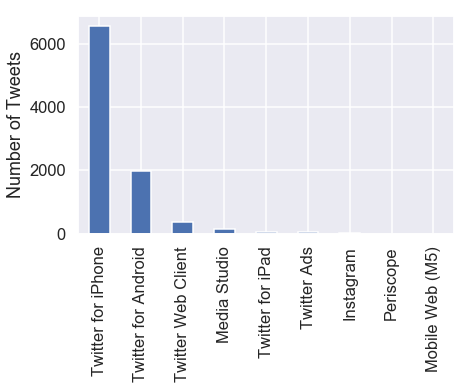

In [25]:
trump['source'].value_counts().plot(kind="bar")
plt.ylabel("Number of Tweets")
plt.show()

### Analysis of Trumps Tweets between different Sources (devices)

In [26]:
for t in trump_tweets[0:3]:
    print(t['created_at'])

Sun Oct 21 00:36:13 +0000 2018
Sat Oct 20 20:12:52 +0000 2018
Sat Oct 20 16:30:00 +0000 2018


In [27]:
trump['est_time'] = (
    trump['time'].dt.tz_localize("UTC") # Set initial timezone to UTC
                 .dt.tz_convert("EST") # Convert to Eastern Time
)
trump.head()

,time,source,text,retweet_count,est_time
id,,,,,
690171032150237184,2016-01-21 13:56:11,Twitter for Android,"""@bigop1: @realDonaldTrump @SarahPalinUSA https://t.co/3kYQGqeVyD""",1059,2016-01-21 08:56:11-05:00
690171403388104704,2016-01-21 13:57:39,Twitter for Android,"""@AmericanAsPie: @glennbeck @SarahPalinUSA Remember when Glenn gave out gifts to ILLEGAL ALIENS at crossing the border? Me too!""",1339,2016-01-21 08:57:39-05:00
690173226341691392,2016-01-21 14:04:54,Twitter for Android,So sad that @CNN and many others refused to show the massive crowd at the arena yesterday in Oklahoma. Dishonest reporting!,2006,2016-01-21 09:04:54-05:00
690176882055114758,2016-01-21 14:19:26,Twitter for Android,"Sad sack @JebBush has just done another ad on me, with special interest money, saying I won't beat Hillary - I WILL. But he can't beat me.",2266,2016-01-21 09:19:26-05:00
690180284189310976,2016-01-21 14:32:57,Twitter for Android,Low energy candidate @JebBush has wasted $80 million on his failed presidential campaign. Millions spent on me. He should go home and relax!,2886,2016-01-21 09:32:57-05:00


In [28]:
hour = trump['est_time'].dt.hour
minutes = trump['est_time'].dt.minute /60
seconds = trump['est_time'].dt.second / 60 **2

trump['hour'] = hour + minutes + seconds

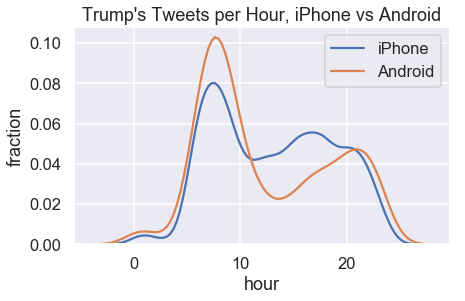

In [29]:
android = trump[trump['source'] == "Twitter for Android"]
iphone = trump[trump['source'] == "Twitter for iPhone"]

sns.distplot(iphone['hour'], hist=False, label='iPhone')
sns.distplot(android['hour'], hist=False, label='Android')
plt.ylabel("fraction")
plt.title("Trump's Tweets per Hour, iPhone vs Android")
plt.show()

According to [this Verge article](https://www.theverge.com/2017/3/29/15103504/donald-trump-iphone-using-switched-android), Donald Trump switched from an Android to an iPhone sometime in March 2017.

During the campaign, it was theorized that Donald Trump's tweets from Android were written by him personally, and the tweets from iPhone were from his staff. 

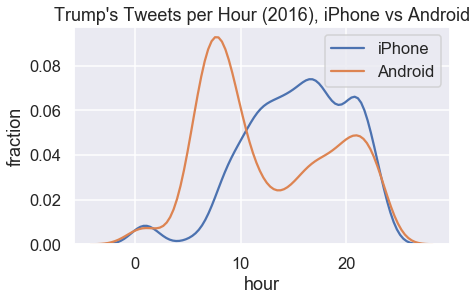

In [30]:
android2016 = android[android["time"].dt.year == 2016]
iphone2016 = iphone[iphone["time"].dt.year == 2016]

sns.distplot(iphone2016['hour'], hist=False, label='iPhone')
sns.distplot(android2016['hour'], hist=False, label="Android")
plt.ylabel("fraction")
plt.title("Trump's Tweets per Hour (2016), iPhone vs Android")
plt.show()

Looking at this plot, clearly there is a difference in usage of the source devices. Does this confirm that the tweets are from his staff or by Trump personally? <br>
It is entirely possible that Trump tweets on both devices at the same time, but it is more likely that his staff is tweeting for him. 

Let's now look at which device he has used over the entire time period of this dataset.

To examine the distribution of dates we will convert the date to a fractional year that can be plotted as a distribution.

(Code borrowed from https://stackoverflow.com/questions/6451655/python-how-to-convert-datetime-dates-to-decimal-years)

In [31]:
import datetime
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length


trump['year'] = trump['time'].apply(year_fraction)

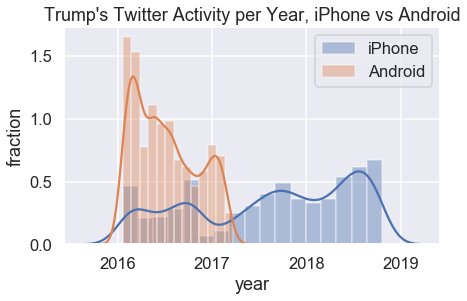

In [32]:
iphoneYear = trump[trump['source'] == 'Twitter for iPhone']
androidYear = trump[trump['source'] == 'Twitter for Android']

sns.distplot(iphoneYear['year'], label="iPhone")
sns.distplot(androidYear['year'], label="Android")
plt.ylabel("fraction")
plt.title("Trump's Twitter Activity per Year, iPhone vs Android")
plt.legend()
plt.show()

## Sentiment Analysis

It turns out that we can use the words in Trump's tweets to calculate a measure of the sentiment of the tweet. For example, the sentence "I love America!" has positive sentiment, whereas the sentence "I hate taxes!" has a negative sentiment. In addition, some words have stronger positive / negative sentiment than others: "I love America." is more positive than "I like America."

We will use the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of Trump's tweets. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which is great for our usage.

The VADER lexicon gives the sentiment of individual words. Run the following cell to show the first few rows of the lexicon:

In [33]:
print(''.join(open("vader_lexicon.txt").readlines()[:10]))

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]



The first column of the lexicon is the *token*, or the word itself. The second column is the *polarity* of the word, or how positive / negative it is.

In [ ]:
sent = pd.read_table("vader_lexicon.txt", sep="\t", header = None, index_col=0)
sent = sent.drop(columns = [2, 3])
sent.index.name = "lexicon"
sent = sent.rename(columns={1:"polarity"})

In [37]:
sent.head()

,polarity
lexicon,
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7


In [38]:
trump['text'] = trump['text'].str.lower()

In [39]:
trump['text'].head()

id
690171032150237184                                                                             "@bigop1: @realdonaldtrump  @sarahpalinusa https://t.co/3kyqgqevyd"
690171403388104704               "@americanaspie:  @glennbeck @sarahpalinusa remember when glenn gave out gifts to illegal aliens at crossing the border? me too!"
690173226341691392                     so sad that @cnn and many others refused to show the massive crowd at the arena yesterday in oklahoma. dishonest reporting!
690176882055114758      sad sack @jebbush has just done another ad on me, with special interest money, saying i won't beat hillary - i will. but he can't beat me.
690180284189310976    low energy candidate @jebbush has wasted $80 million on his failed presidential campaign. millions spent on me. he should go home and relax!
Name: text, dtype: object

Gets rid of punctuation so that words will match without failure. 

In [40]:
punct_re = r'[^\w\s]'
trump['no_punc'] = trump['text'].str.replace(punct_re, repl=" ")

Convert the tweets into what's called a [*tidy format*](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) to make the sentiments easier to calculate.

1. `num`: The location of the word in the tweet. For example, if the tweet was "i love america", then the location of the word "i" is 0, "love" is 1, and "america" is 2.
2. `word`: The individual words of each tweet.

In [41]:
tidy_format = trump['no_punc'].str.split(expand=True).stack().reset_index(level=1).rename(columns={"level_1":'num', 0:'word'})

In [42]:
tidy_format.head()

,num,word
id,,
690171032150237184,0,bigop1
690171032150237184,1,realdonaldtrump
690171032150237184,2,sarahpalinusa
690171032150237184,3,https
690171032150237184,4,t


Calculate the polarity of each word by merging the tidy_format and sent tables

In [43]:
polarity = tidy_format.merge(sent, how = 'left', left_on= 'word', right_index=True)
trump['polarity'] = polarity.groupby("id")["polarity"].sum()

In [44]:
trump.head()

,time,source,text,retweet_count,est_time,hour,year,no_punc,polarity
id,,,,,,,,,
690171032150237184,2016-01-21 13:56:11,Twitter for Android,"""@bigop1: @realdonaldtrump @sarahpalinusa https://t.co/3kyqgqevyd""",1059,2016-01-21 08:56:11-05:00,8.936389,2016.054645,bigop1 realdonaldtrump sarahpalinusa https t co 3kyqgqevyd,0.0
690171403388104704,2016-01-21 13:57:39,Twitter for Android,"""@americanaspie: @glennbeck @sarahpalinusa remember when glenn gave out gifts to illegal aliens at crossing the border? me too!""",1339,2016-01-21 08:57:39-05:00,8.960833,2016.054645,americanaspie glennbeck sarahpalinusa remember when glenn gave out gifts to illegal aliens at crossing the border me too,-2.6
690173226341691392,2016-01-21 14:04:54,Twitter for Android,so sad that @cnn and many others refused to show the massive crowd at the arena yesterday in oklahoma. dishonest reporting!,2006,2016-01-21 09:04:54-05:00,9.081667,2016.054645,so sad that cnn and many others refused to show the massive crowd at the arena yesterday in oklahoma dishonest reporting,-6.0
690176882055114758,2016-01-21 14:19:26,Twitter for Android,"sad sack @jebbush has just done another ad on me, with special interest money, saying i won't beat hillary - i will. but he can't beat me.",2266,2016-01-21 09:19:26-05:00,9.323889,2016.054645,sad sack jebbush has just done another ad on me with special interest money saying i won t beat hillary i will but he can t beat me,4.3
690180284189310976,2016-01-21 14:32:57,Twitter for Android,low energy candidate @jebbush has wasted $80 million on his failed presidential campaign. millions spent on me. he should go home and relax!,2886,2016-01-21 09:32:57-05:00,9.549167,2016.054645,low energy candidate jebbush has wasted 80 million on his failed presidential campaign millions spent on me he should go home and relax,-2.6


We now have the sentiment calculation of each Tweet by Donald Trump

In [45]:
#Trumps most negative tweets
print('Most negative tweets:')
for t in trump.sort_values('polarity').head()['text']:
    print('\n  ', t)

Most negative tweets:

   it is outrageous that poisonous synthetic heroin fentanyl comes pouring into the u.s. postal system from china. we can, and must, end this now! the senate should pass the stop act – and firmly stop this poison from killing our children and destroying our country. no more delay!

   the rigged russian witch hunt goes on and on as the “originators and founders” of this scam continue to be fired and demoted for their corrupt and illegal activity. all credibility is gone from this terrible hoax, and much more will be lost as it proceeds. no collusion!

   james comey is a proven leaker &amp; liar. virtually everyone in washington thought he should be fired for the terrible job he did-until he was, in fact, fired. he leaked classified information, for which he should be prosecuted. he lied to congress under oath. he is a weak and.....

   this is an illegally brought rigged witch hunt run by people who are totally corrupt and/or conflicted. it was started and paid 

In [46]:
#Trumps most positive Tweets
print('Most positive tweets:')
for t in trump.sort_values('polarity', ascending=False).head()['text']:
    print('\n  ', t)

Most positive tweets:

   congratulations to patrick reed on his great and courageous masters win! when patrick had his amazing win at doral 5 years ago, people saw his great talent, and a bright future ahead. now he is the masters champion!

   my supporters are the smartest, strongest, most hard working and most loyal that we have seen in our countries history. it is a beautiful thing to watch as we win elections and gather support from all over the country. as we get stronger, so does our country. best numbers ever!

   thank you to all of my great supporters, really big progress being made. other countries wanting to fix crazy trade deals. economy is roaring. supreme court pick getting great reviews. new poll says trump, at over 90%, is the most popular republican in history of the party. wow!

   thank you, @wvgovernor jim justice, for that warm introduction. tonight, it was my great honor to attend the “greenbrier classic – salute to service dinner” in west virginia! god bless ou

### Plots of Trumps Tweets (Comparing Sentiment)

Comparing Trumps Tweet polarity with the keywords of news sources he targets in his tweets

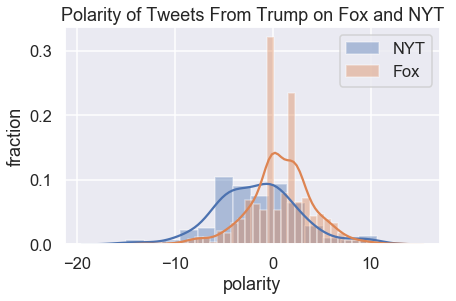

In [47]:
nyt = trump[trump["no_punc"].str.contains('nyt')]['polarity']
fox =  trump[trump["no_punc"].str.contains('fox')]['polarity']

sns.distplot(trump.loc[nyt.index.values]["polarity"], label = "NYT")
sns.distplot(trump.loc[fox.index.values]["polarity"], label = "Fox") 
plt.ylabel("fraction")
plt.legend()
plt.title("Polarity of Tweets From Trump on Fox and NYT")
plt.show()

The polarity for fox is more positive in Trump's tweets. The polarity for tweets about nyt are more negative, probably due to some conflicting opinions about Mr. Trump. But overall there are a higher fraction of tweets about fox than nyt. 

## Top Retweeted Words from Donald Trumps Twitter

In [48]:
top_retweets = trump.merge(tidy_format, left_index = True, right_index = True).groupby("word").aggregate({'retweet_count':'mean', 'num':'count'})
top_20 = top_retweets[top_retweets['num'] >= 25].sort_values("retweet_count", ascending=False).drop(columns = 'num').iloc[:20]
top_20.head()

,retweet_count
word,
jong,40564.400000
try,33897.200000
un,32654.878049
kim,32208.428571
maybe,30391.884615


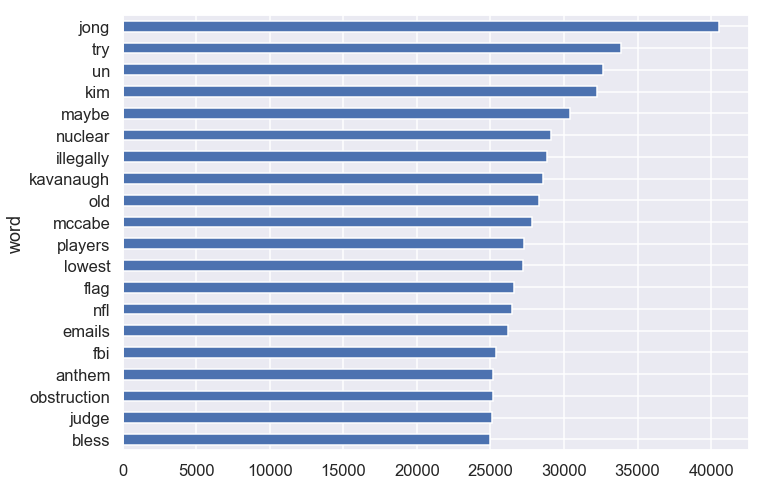

In [49]:
top_20['retweet_count'].sort_values().plot.barh(figsize=(10, 8));

## Polarity of Trumps Tweets vs. Retweet Counts

I want to examine the polarity of Trumps tweets and see if that polarity has any effect on retweet counts

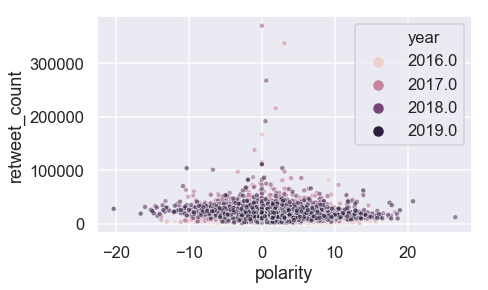

In [50]:
sns.scatterplot(x = "polarity", y = "retweet_count", data = trump, alpha = 0.6, hue="year", s=25)
plt.show()

In [51]:
trump["year_rounded"] = np.floor(trump['year'])

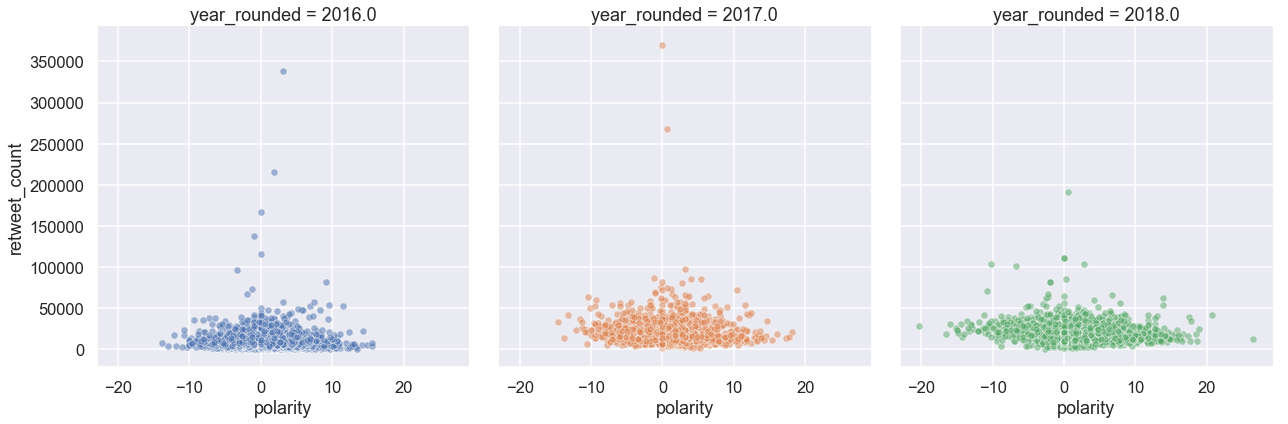

In [52]:
plotGrid = sns.FacetGrid(trump, col = "year_rounded", hue = "year_rounded", margin_titles=True, height=6)
plotGrid.map(sns.scatterplot, "polarity", "retweet_count", alpha=.5,s = 50)
plt.show()

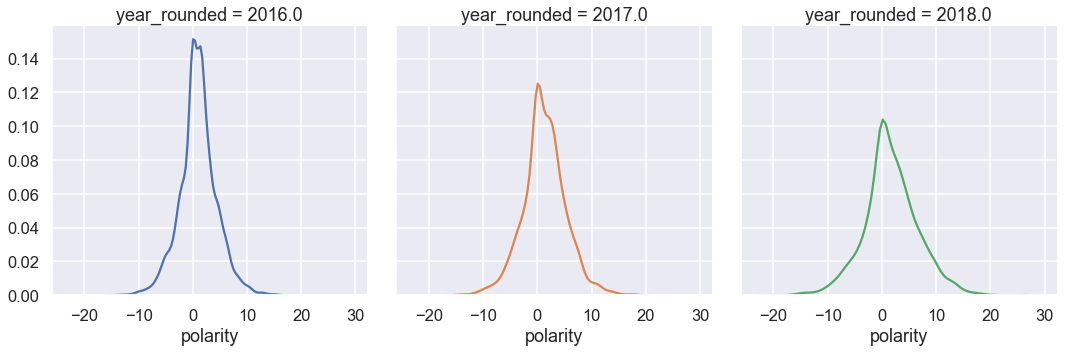

In [53]:
plotGrid2 = sns.FacetGrid(trump, col = "year_rounded", hue="year_rounded", height = 5)
plotGrid2.map(sns.distplot, "polarity", hist=False)
plt.show()

From the plots shown here, we can see that sentiment does have some value into the amount of retweets a tweet gets. Particularly tweets that are around 0 polarity, such as slightly less and slightly more, get the most retweets, showing that these Tweets aren't extreme, but just right enough to get a lot of retweets. However, these could be outlier events such that the retweet count is correlated with some event in the world that more people pay attention to. <br>
We can also see that early in 2016, the tweets polarity stayed in between some finer points, suggesting that since it was Trumps campaign, he restricted to Tweeting things that weren't to out of scope in terms of negative words. (However, the polarity detection doesn't include the meaning behind the Tweets sent and very specific words that aren't feeling related.) 
But in 2018 so far, Trump's tweets are more spread in both postive and negative polarity, suggesting he has let lose with some of his restrictive language. <br>
Also, since very high retweet counts are very sparse, it is most likely those Tweets involve more specific events that I noted earlier. If we can confirm this, then we can conclude polarity doesn't have that much effect on the retweet count of tweets. 